# Extract grid or subgrid in Graph data type.
This one of the first steps into modelling Gaussian Markov Random Fields (GMRF).
1. The first step is to extract a subgrid given a polygon.
2. Extract the neighbours of the selected cells. 
3. Take the Union of that
4. Create an adjancency matrix
5. Rearrange the nodes
6. Model the GMRF

In [1]:
%matplotlib inline
import sys
sys.path.append('/apps')
import django
django.setup()
from drivers.tree_builder import TreeNeo
from drivers.graph_models import TreeNode, Order, Family, graph,Kingdom,Occurrence
from drivers.graph_models import Cell,Mex4km, countObjectsOf
from drivers.graph_models import pickNode
import matplotlib.pyplot as plt
import pandas as pd
import itertools as it

import numpy as np

## Use the ggplot style
plt.style.use('ggplot')

In [2]:
from sketches.models import Country
from mesh.models import MexMesh
from traversals.sampling import UniformRandomCellSample
from drivers.graph_models import Cell,Mex4km
from traversals.strategies import idsToCells,LatticeToNetworkx
import networkx as nx
Mexico = Country.objects.filter(name__contains="exico").get()
mexican_cells = MexMesh.objects.filter(cell__intersects=Mexico.geom)

In [3]:
mexican_cells.count()

74200

In [4]:
#from django.contrib.gis.geos import GEOSGeometry
#polygon = GEOSGeometry(polystr)
#subselection_cells = MexMesh.objects.filter(cell__intersects=polygon)

In [9]:
# Get all cell ids Inside the polygon
ids = list(mexican_cells.values('pk'))
CellNodeClass = Mex4km
list_of_cell_ids = map(lambda dic : dic['pk'], ids)
#selection = idsToCells(list_of_cell_ids)
#%time ll = list(selection)

In [10]:
selection = idsToCells(list_of_cell_ids)

INFO Compiling Query and asking the Graph Database


In [11]:
## Convert cell selection and convert it to a lattice (neighbourhood degree 1). This neighbourhood is a Networkx object.
%time lattice = LatticeToNetworkx(selection)

CPU times: user 2h 42min 53s, sys: 12min 27s, total: 2h 55min 21s
Wall time: 8h 1min 56s


64

In [18]:
%time nx.write_graph6(G=lattice,path="/outputs/fullmex4kmlattice.g6")

MemoryError: 

In [12]:
## Meaning that we can use the networkx library to obtain the adjacency matrix.
%time M = nx.adjacency_matrix(lattice).toarray()
# Which we can plot, as well.
#plt.imshow(M,cmap=plt.cm.Greys)

MemoryError: 

## Unconditional simulation
Here I'll explain how to do a simulation following algorithm 2.4 from: *Gaussian Markov Random Fields*

In [17]:
### HIGHLY EXPERIMENTAL
import external_plugins.spystats.spystats.tools as spt

In [21]:
mtv = spt.MaternVariogram(sill=0.2,range_a=0.5)

In [24]:
X = np.linspace(0,3,100)

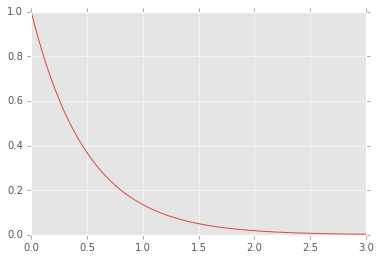

In [28]:
plt.plot(X,mtv.corr_f(X))

In [148]:
import numpy as np
import scipy

In [149]:
## Make the diagonal big enough to assure SPD 
I = np.eye(M.shape[0])
M_star = M + (30* I)

In [150]:
z = scipy.stats.norm.rvs(size=I.shape[0])

In [151]:
%time L = scipy.linalg.cholesky(M_star)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 2.85 ms


In [152]:
v = scipy.linalg.solve(L.transpose(),z)

## Diversion>
Extracting coordinates (or other data from the graph)


In [153]:
nnn = lattice.nodes()

In [154]:
lcoords = map(lambda n : n.centroid.get_coords(),lattice.nodes())

In [155]:
c = pd.DataFrame(zip(*lcoords)).transpose()
c.columns = ['Lon','Lat']

In [156]:

cc = spy.spystats.tools.toGeoDataFrame(c,'Lon','Lat')

In [157]:
v = pd.DataFrame({'sim':v})

In [158]:

ccc = pd.concat([cc,v],axis =1)


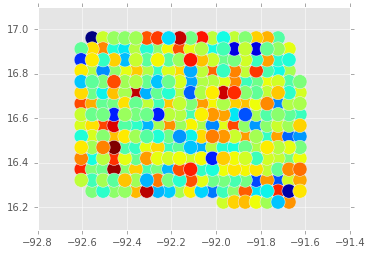

In [159]:
ccc.plot(column='sim',s=200)

In [160]:
Z = pd.DataFrame({'rand':z})
allrand = pd.concat([ccc,Z],axis=1)

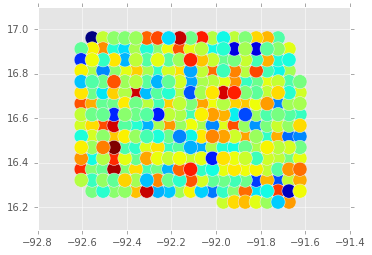

In [161]:
allrand.plot(column='rand',s=200)

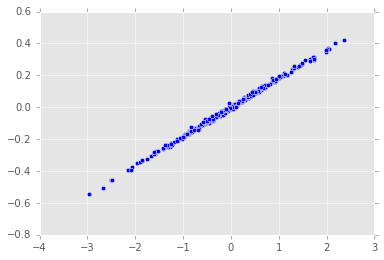

In [164]:
plt.scatter(allrand['rand'],allrand.sim)

NO SHIRVE!